## Optimizing Personalized Treatment Strategies for Acute Hypotensive Patients

Description of Environment:

1. State Space: The state space represents the current condition of the patient which includes:
    * Vital signs: Heart rate, systolic and diastolic blood pressure, respiratory rate, oxygen saturation, etc.
    * Biochemical markers: Blood pH, lactate levels, creatinine, and other lab results that provide insights into organ function
    * Demographics and medical history: Patient age, gender, weight, comorbidities (e.g. diabetes, renal failure)
    * Previous treatment: Prior medication dosages and fluid levels administered during the current ICU stay. 

2. Action Space: Discrete treatment actions that a clinician could take to manage acute hypotension in ICU patients. This may include: 
    * Fluid Administration (e.g. low, medium, high dosage)
    * Vasopressor administration (e.g. low, medium, high dosage)
    * No intervention (wait and observe)
    Each of these actions will have an immediate impact on the patient’s state (e.g. vital signs, biochemical markers), making it crucial to optimize the sequence of actions based on the patient’s evolving condition. 

3. Reward Function: The reward at time step $t$ is dependent on the Mean Arterial Pressure $MAP_t$ and is given by:

$$\text{reward}_t = \begin{cases}
0 & \text{if MAP$_t > 65$} \\
\frac{-0.05(65-\text{MAP}_t)}{5} & \text{if $60 < \text{MAP}_t \le 65$} \\
\frac{-0.1(60-\text{MAP}_t)}{5}-0.05 & \text{if $55 < \text{MAP}_t \le 60$} \\
\frac{-0.85(55-\text{MAP}_t)}{15}-0.15 & \text{if $\text{MAP}_t \le 55$} \\
\end{cases}$$

But the reward value is also dictated, and overwritten by the urine output at time step t:

$$\text{reward}_t = 0 \text{ if urine}_t >30\text{ and MAP}_t >55$$

The objective of the project is to develop an AI-based decision support system that assists clinicians in personalizing treatment strategies for acute hypotension. We will :

* Learn to recommend optimal treatments based on patient-specific data, adapting in real-time to their evolving condition.
* Compare the performance of model-free approaches with model-based techniques to identify which provides more reliable and clinically relevant reccomendations
* Use off-policy evaluation methods such as weighted importance sampling and bootstrapping to ensure safe and effective policies without real-world deployment. 


---

### 0. Split Train Test

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# load data
df = df = pd.read_csv('Data/C001_FakeHypotension.csv')
print(f'Number of unique patients: {df["PatientID"].nunique()}')
num_patients = df['PatientID'].nunique()

# rename columns
df.rename(columns={"PatientID": "id", "Timepoints": "hour"}, inplace=True)

Number of unique patients: 3910


In [3]:
# reward function
def reward_function(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward

# add the reward to the data
df['reward'] = df.apply(lambda row: reward_function(row), axis=1)
# shift one up so that reward is in the same row of action
df['reward'] = df['reward'].shift(-1)

In [4]:
# encode action to action number
fluid_boluses_dict = {
    **dict.fromkeys([0, 1, 2, 3], '[0, 250)'),
    **dict.fromkeys([4, 5, 6, 7], '[250, 500)'),
    **dict.fromkeys([8, 9, 10, 11], '[500, 1000)'),
    **dict.fromkeys([12, 13, 14, 15], '>= 1000')
}
vasopressors_dict = {
    **dict.fromkeys([0, 4, 8, 12], '0'),
    **dict.fromkeys([1, 5, 9, 13], '(0, 8.4)'),
    **dict.fromkeys([2, 6, 10, 14], '[8.4, 20.28)'),
    **dict.fromkeys([3, 7, 11, 15], '>= 20.28')
}

fluid_boluses_mapping = {v:i for i,v in enumerate(sorted(df['fluid_boluses'].unique()))}
vasopressors_mapping = {v:i for i,v in enumerate(sorted(df['vasopressors'].unique()))}
df['fluid_boluses'] = df['fluid_boluses'].map(fluid_boluses_mapping)
df['vasopressors'] = df['vasopressors'].map(vasopressors_mapping)
df['action_number'] = 4 * df['fluid_boluses'] + df['vasopressors']

In [5]:
# split train test
seed = 42
np.random.seed(seed)

train_ratio = 0.8
num_train_samples = int(num_patients * train_ratio)
train_ids = np.random.choice(num_patients, num_train_samples)
print(f'Number of patients in train data: {len(train_ids)}')

train_df = df[df["id"].isin(train_ids)].reset_index(drop=True)
test_df = df[~df["id"].isin(train_ids)].reset_index(drop=True)

print(f'Train Data: {train_df.shape}')
print(f'Test Data: {test_df.shape}')

Number of patients in train data: 3128
Train Data: (101376, 25)
Test Data: (86304, 25)


### 1. Tabular Q-Learning (Following HealthGym's tutorial)

Prepare data:

In [6]:
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import PLSCanonical

In [8]:
# columns for states and actions
actions = ["fluid_boluses", "vasopressors"]
state_columns = ["MAP", "diastolic_bp", "systolic_bp", "urine", "ALT", "AST", "PO2", "lactic_acid", "serum_creatinine", "FiO2", 
          "GCS_total", "urine_m", "ALT_AST_m", "FiO2_m", "GCS_total_m", "PO2_m", "lactic_acid_m", "serum_creatinine_m"]

In [9]:
# cross decomposition to reduce dimensionality
train_df_state = train_df[state_columns]
train_df_action = train_df[actions]
train_df_action = pd.get_dummies(train_df_action, prefix=["fluid_boluses", "vasopressors"], columns=["fluid_boluses", "vasopressors"])

# partial least squares regression
plsca = PLSCanonical(n_components=5)

X = train_df_state.astype(float).values
Y = train_df_action.astype(float).values
X_norm = (X - X.mean(axis=0)) / (X.std(axis=0))
Y_norm = (Y - Y.mean(axis=0)) / (Y.std(axis=0))
X_canonical, Y_canonical = plsca.fit_transform(X_norm, Y_norm)

In [10]:
# k-means clustering to assign each patient to 1 cluster
num_states = 100
kmeans = KMeans(n_clusters=num_states, n_init=10, random_state=123)

state_numbers = kmeans.fit(X_canonical).labels_

We add the following variables:
* `hour`: time point between 0 and 47
* `action_number`: number between 0 and 15 indicating the action taken
* `state_number`: cluster asociated with the state at time t
* `state_number_tp1`: cluster associated with the state at time t+1

In [10]:
# add state number
X_train = train_df.copy()

X_train['state_number'] = state_numbers
X_train['state_number_tp1'] = X_train['state_number'].shift(-1)

X_train.head()

,Unnamed: 0,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,PO2,lactic_acid,serum_creatinine,...,GCS_total_m,PO2_m,lactic_acid_m,serum_creatinine_m,id,hour,reward,action_number,state_number,state_number_tp1
0,48,39.952660,29.214905,108.805710,425.59628,19.907928,41.239155,99.31541,1.202458,0.925502,...,0,0,0,1,1,0,0.000000,8,24,49.0
1,49,68.468155,54.808110,101.934395,141.29442,28.589739,37.192097,95.09573,1.980157,1.350632,...,1,0,0,0,1,1,0.000000,1,49,24.0
2,50,57.901825,49.352460,98.348130,168.83945,21.603394,32.510864,116.30304,1.705058,1.007780,...,0,0,0,1,1,2,0.000000,1,24,75.0
3,51,64.464700,49.554610,104.063640,152.57677,29.738842,36.389750,115.09922,1.942347,1.357720,...,0,0,0,0,1,3,0.000000,1,75,19.0
4,52,77.893555,66.831276,115.173450,126.08959,27.832410,35.918148,98.64675,1.797520,1.080140,...,0,0,0,0,1,4,-1.100548,1,19,34.0


In [11]:
# ignore last hour since we don't observe reward of the last state
X_train = X_train[X_train["hour"] < 47]
X_train["state_number_tp1"] = X_train["state_number_tp1"].astype(int)

A simple algorithm for offline reinforcement learning (where we are given a fixed batch of data and can’t interact with the environment to collect new data) is Batch-Constrained Q-learning (BCQL). It determines an optimal policy in a way similar to standard Q-learning, except that the max over action values in the next state is taken only over actions that have actually been observed in the data.

In [12]:
# q-learning
Q = np.full((100, 16), np.nan, dtype='float') # 100 states, 16 actions

# Set to 0 if state-action combination has actually been observed in the data
for index, row in X_train.iterrows():
    state_number = int(row['state_number'])
    action_number = int(row['action_number'])
    Q[state_number, action_number] = 0

# parameters
num_iterations = 300
step_size = 0.1
gamma = 0.99
diff_tracker = np.zeros((num_iterations, 1))

# q-learning loop
for Q_iter in range(num_iterations):
    Q_old = Q.copy()
    for index, row in X_train.iterrows():
        state_number = int(row['state_number'])
        action_number = int(row['action_number'])
        state_number_tp1 = int(row['state_number_tp1'])
        Q[state_number, action_number] += step_size * (row['reward'] + gamma * np.nanmax(Q[state_number_tp1, :]) - Q[state_number, action_number])
    diff_tracker[Q_iter] = np.nanmean(np.abs(Q-Q_old))

    if (Q_iter > 0) and (Q_iter % 10 == 0):
        print(f"[Step {Q_iter}] Difference in Q-values: {diff_tracker[Q_iter][0]}")

[Step 10] Difference in Q-values: 0.0008632408002870604
[Step 20] Difference in Q-values: 0.00023965148263900245
[Step 30] Difference in Q-values: 7.853201287151403e-05
[Step 40] Difference in Q-values: 2.6852447632753353e-05
[Step 50] Difference in Q-values: 9.306193066916596e-06
[Step 60] Difference in Q-values: 3.239913197981494e-06
[Step 70] Difference in Q-values: 1.129728718751889e-06
[Step 80] Difference in Q-values: 3.941400201655222e-07
[Step 90] Difference in Q-values: 1.375335463348281e-07
[Step 100] Difference in Q-values: 4.799488981545824e-08
[Step 110] Difference in Q-values: 1.674908105095084e-08
[Step 120] Difference in Q-values: 5.845075310725627e-09
[Step 130] Difference in Q-values: 2.039811901279939e-09
[Step 140] Difference in Q-values: 7.118528491012444e-10
[Step 150] Difference in Q-values: 2.484220585316309e-10
[Step 160] Difference in Q-values: 8.669415435985847e-11
[Step 170] Difference in Q-values: 3.0254442232468724e-11
[Step 180] Difference in Q-values: 1.

**Evaluation**

The expected value of the RL policy can now be compared to the value of the original clinical policy or a random policy. The expected value of the RL policy is higher than for the other policies.

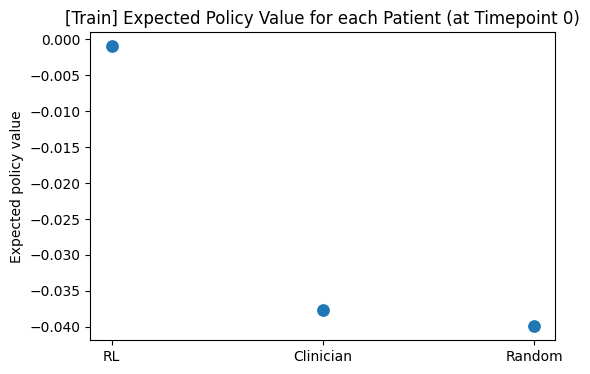

In [13]:
# evaluation on training data
Q_RL = 0
Q_random = 0
Q_clinician = 0

for index, row in X_train.iterrows():
    if row["hour"] == 0:
        # rl policy
        Q_RL += np.nanmax(Q[int(row['state_number']), :])

        # clinician policy
        Q_clinician += Q[int(row['state_number']), int(row['action_number'])]
        
        # random policy
        h = Q[int(row['state_number']), :]
        h = h[~np.isnan(h)]
        Q_random += h[np.random.choice(h.shape[0], 1)][0]

Q_RL = Q_RL / num_patients
Q_clinician = Q_clinician / num_patients
Q_random = Q_random / num_patients

plt.figure(figsize=(6, 4))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], markers='s', s=100)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (at Timepoint 0)')
plt.show()

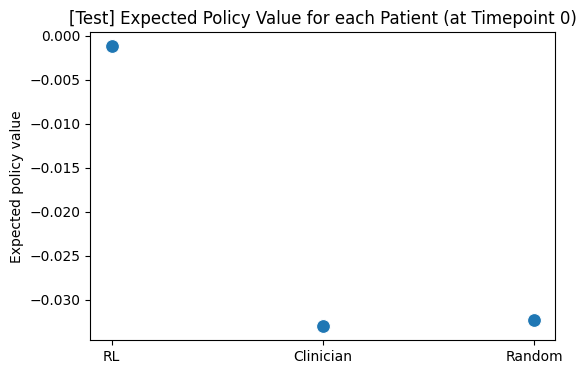

In [14]:
# normalize the test data
test_df_state = test_df[state_columns]
X_test_state = test_df_state.astype(float).values
X_test_norm = (X_test_state - X.mean(axis=0)) / X.std(axis=0)

# apply PLSCanonical to test data
X_test_canonical = plsca.transform(X_test_norm)

# apply k-means to get state numbers
test_state_numbers = kmeans.predict(X_test_canonical)

# add state numbers to test data
X_test = test_df.copy()
X_test["state_number"] = test_state_numbers

# evaluation on test data
Q_RL = 0
Q_random = 0
Q_clinician = 0

for index, row in X_test.iterrows():
    if row["hour"] == 0:
        # rl policy
        Q_RL += np.nanmax(Q[int(row['state_number']), :])

        # clinician policy
        Q_clinician += Q[int(row['state_number']), int(row['action_number'])]
        
        # random policy
        h = Q[int(row['state_number']), :]
        h = h[~np.isnan(h)]
        Q_random += h[np.random.choice(h.shape[0], 1)][0]

Q_RL = Q_RL / num_patients
Q_clinician = Q_clinician / num_patients
Q_random = Q_random / num_patients

plt.figure(figsize=(6, 4))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], markers='s', s=100)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (at Timepoint 0)')
plt.show()

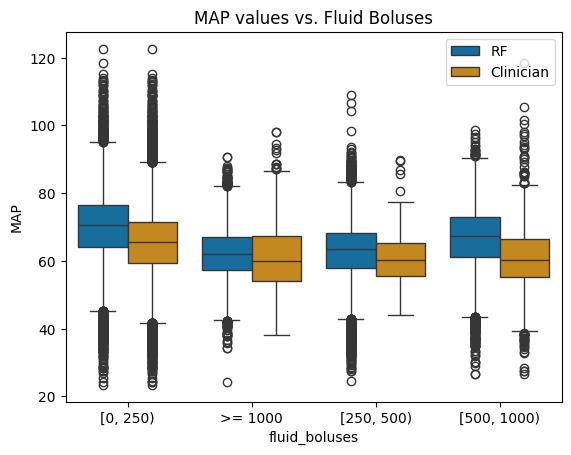

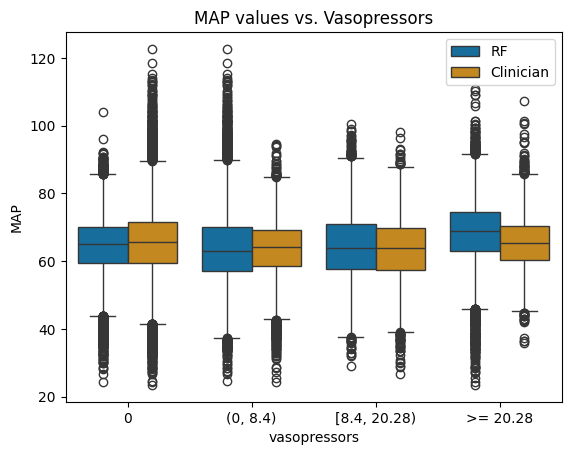

In [17]:
# MAP values for each action taken (test data)
df_boxplot_RF = X_test[['MAP']]
df_boxplot_RF['action_number'] = 0
for index, row in X_test.iterrows():
    df_boxplot_RF.at[index, 'action_number'] = np.nanargmax(Q[int(row['state_number']), :])

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = X_test[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP values vs. Fluid Boluses")
plt.show()

sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP values vs. Vasopressors")
plt.show()

---

### 2. Discrete Batch Constrained Deep Q-Learning



In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque

Preprocess data - scale the state columns:

In [12]:
# transform the train and test data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(train_df[state_columns]), columns=state_columns)
X_test_scaled = pd.DataFrame(scaler.transform(test_df[state_columns]), columns=state_columns)

# add the necessary columns back
cols = ["id", "hour", "reward", "action_number"]
for col in cols:
    X_scaled[col] = train_df[col]
    X_test_scaled[col] = test_df[col]

Create a replay buffer and store all transitions:

In [14]:
# replay buffer method
class ReplayBuffer:
    def __init__(self, max_size=1000000, batch_size=32):
        self.buffer = deque(maxlen=max_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # convert to tensors
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones)
        )

    def __len__(self):
        return len(self.buffer)

In [15]:
# store the transitions in the training data into the replay buffer
replay_buffer = ReplayBuffer()

for idx, row in X_scaled.iterrows():
    # terminal state, we don't observe reward, ignore
    if row["hour"] == 47: 
        continue
    else:
        id = row["id"]
        hour = row["hour"]

        state = np.array(row[state_columns].values)
        action = int(row["action_number"])
        reward = row["reward"]

        next_state_row = X_scaled[(X_scaled["id"]==id) & (X_scaled["hour"]==hour+1)]
        next_state = np.array(next_state_row[state_columns].values[0])
        done = 0

        replay_buffer.add(state, action, reward, next_state, done)

Set up the offline RL agent:

In [16]:
# get the theoretical bounds of the q-values (we clamp the q-values for better convergence)
gamma = 0.99
v_min = X_scaled['reward'].min() / (1 - gamma)
v_max = X_scaled['reward'].max() / (1 - gamma)
print(f'Theoretical bounds of q-values: [{v_min}, {v_max}]')

Theoretical bounds of q-values: [-216.77837199999976, 0.0]


In [17]:
# behavior cloning model - outputs a distribution over the 16 discrete actions
class BehaviorCloning(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, v_min=v_min, v_max=v_max):
        super(BehaviorCloning, self).__init__()
        self.v_min= v_min
        self.v_max = v_max
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        # weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight, -1e-2, 1e-2)  # Small weights for output layer
        nn.init.uniform_(self.fc3.bias, -1e-2, 1e-2)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.clamp(x, min=self.v_min, max=self.v_max)
    
class Q_Network(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, v_min=v_min, v_max=v_max):
        super(Q_Network, self).__init__()
        self.v_min= v_min
        self.v_max = v_max
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        # weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight, -1e-2, 1e-2)  # Small weights for output layer
        nn.init.uniform_(self.fc3.bias, -1e-2, 1e-2)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.clamp(x, min=self.v_min, max=self.v_max)
    

# BCQ for discrete actions
class DiscreteBCQ:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, bcq_threshold=0.3, target_update_steps=5000, device="mps"):
        self.gamma = gamma
        self.threshold = bcq_threshold
        self.target_update_steps = target_update_steps
        self.device = device

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_network = Q_Network(state_dim, action_dim, hidden_dim).to(device)
        self.target_q_network = Q_Network(state_dim, action_dim, hidden_dim).to(device)
        self.behavior_model = BehaviorCloning(state_dim, action_dim, hidden_dim).to(device)

        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=1e-5)
        self.behavior_optimizer = optim.Adam(self.behavior_model.parameters(), lr=1e-5)

        # copy weights to target model
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # losses
        self.q_losses = []
        self.behavior_losses = []
        self.losses = []

    def select_action(self, states):
        # select action according to policy
        with torch.no_grad():
            # get q values from q-network (using current q_network as in Double DQN)
            q_values = self.q_network(states)

            # calculate action probabilities from behavior model
            behavior_logits = self.behavior_model(states)
            log_action_probs = F.log_softmax(behavior_logits, dim=1)

            # Normalize the log probabilities by subtracting the maximum log probability
            ratio = log_action_probs - log_action_probs.max(dim=1, keepdim=True).values
            # create a mask 
            mask = (ratio > np.log(self.threshold)).float()

            # normalize the q-values by subtracting the min Q-values across actions
            normalized_q_values = q_values - q_values.min(dim=1, keepdim=True).values

            # Apply the mask: zero out Q-values for invalid actions
            masked_q_values = normalized_q_values * mask

            # Select the action with the highest masked Q-value
            next_actions = masked_q_values.argmax(dim=1)
            
            return next_actions
    
    def save_model(self, filepath):
        """Save the Q-network and Target-network to the specified filepath."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_q_network.state_dict(),
            'behavior_network': self.behavior_model.state_dict(),
            'optimizer': self.q_optimizer.state_dict(),
            'behavior_optimizer': self.behavior_optimizer.state_dict()
        }, filepath)

    def load_model(self, filepath):
        """Load the Q-network and Target-network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_q_network.load_state_dict(checkpoint['target_network'])
        self.behavior_model.load_state_dict(checkpoint['behavior_network'])
        if 'optimizer' in checkpoint:
            self.q_optimizer.load_state_dict(checkpoint['optimizer'])
            self.behavior_optimizer.load_state_dict(checkpoint['behavior_optimizer'])
              
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # behavior cloning (cross-entropy loss with one-hot actions)
            behavior_logits = self.behavior_model(states)
            log_probs = F.log_softmax(behavior_logits, dim=1)
            penalty = (behavior_logits ** 2).mean()
            behavior_loss = F.nll_loss(log_probs, actions) + 0.5 * penalty

            # update behavior model
            self.behavior_optimizer.zero_grad()
            behavior_loss.backward()
            self.behavior_optimizer.step()

            # select next action using behavior model
            next_actions = self.select_action(next_states)

            # compute q-targets
            with torch.no_grad():
                q_values_next = self.target_q_network(next_states)
                q_values_next = q_values_next.gather(1, next_actions.unsqueeze(1)).squeeze(1)
                q_targets = rewards + (self.gamma * (1 - dones) * q_values_next)

            # compute current q estimates
            q_current = self.q_network(states)
            q_current = q_current.gather(1, actions.unsqueeze(1)).squeeze(1)

            # q loss
            q_loss = F.smooth_l1_loss(q_current, q_targets) 

            # update q-network
            self.q_optimizer.zero_grad()
            q_loss.backward()
            self.q_optimizer.step()

            # hard update for target q
            if (iteration > 0) and (iteration % self.target_update_steps == 0):
                self.target_q_network.load_state_dict(self.q_network.state_dict())

            # store loss
            self.q_losses.append(q_loss.item())
            self.behavior_losses.append(behavior_loss.item())
            self.losses.append(q_loss.item() + behavior_loss.item())

            if (iteration > 0) and (iteration % 5000 == 0):
                avg_q_loss = sum(self.q_losses[-5000:]) / 5000
                avg_b_loss = sum(self.behavior_losses[-5000:]) / 5000
                total_avg_loss = sum(self.losses[-5000:]) / 5000
                print(f'[Step {iteration}/{num_steps}] Loss: {total_avg_loss:.8f}\tAvg Q-Loss: {avg_q_loss:.8f}\tAvg Imitator Loss: {avg_b_loss:.8f}')

In [18]:
# train the agent
discrete_bcq_agent = DiscreteBCQ(state_dim=18, action_dim=16, hidden_dim=128)
discrete_bcq_agent.train(replay_buffer, num_steps=200000)

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_39647/3817495509.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  torch.FloatTensor(states),


[Step 5000/200000] Loss: 2.52221494	Avg Q-Loss: 0.01524552	Avg Imitator Loss: 2.50696943
[Step 10000/200000] Loss: 2.45818990	Avg Q-Loss: 0.01466139	Avg Imitator Loss: 2.44352851
[Step 15000/200000] Loss: 2.45208569	Avg Q-Loss: 0.01443826	Avg Imitator Loss: 2.43764743
[Step 20000/200000] Loss: 2.44948577	Avg Q-Loss: 0.01428130	Avg Imitator Loss: 2.43520446
[Step 25000/200000] Loss: 2.44765989	Avg Q-Loss: 0.01410583	Avg Imitator Loss: 2.43355407
[Step 30000/200000] Loss: 2.44611274	Avg Q-Loss: 0.01414095	Avg Imitator Loss: 2.43197179
[Step 35000/200000] Loss: 2.44459388	Avg Q-Loss: 0.01403294	Avg Imitator Loss: 2.43056094
[Step 40000/200000] Loss: 2.44234401	Avg Q-Loss: 0.01372028	Avg Imitator Loss: 2.42862372
[Step 45000/200000] Loss: 2.44214712	Avg Q-Loss: 0.01422858	Avg Imitator Loss: 2.42791854
[Step 50000/200000] Loss: 2.44187372	Avg Q-Loss: 0.01411787	Avg Imitator Loss: 2.42775585
[Step 55000/200000] Loss: 2.44103024	Avg Q-Loss: 0.01400073	Avg Imitator Loss: 2.42702951
[Step 60000

In [22]:
# continue training 
discrete_bcq_agent.train(replay_buffer, num_steps=200000)

[Step 5000/200000] Loss: 2.42975044	Avg Q-Loss: 0.01313368	Avg Imitator Loss: 2.41661676
[Step 10000/200000] Loss: 2.42977211	Avg Q-Loss: 0.01316286	Avg Imitator Loss: 2.41660925
[Step 15000/200000] Loss: 2.42939755	Avg Q-Loss: 0.01320928	Avg Imitator Loss: 2.41618827
[Step 20000/200000] Loss: 2.42859064	Avg Q-Loss: 0.01303304	Avg Imitator Loss: 2.41555760
[Step 25000/200000] Loss: 2.42831735	Avg Q-Loss: 0.01294025	Avg Imitator Loss: 2.41537710
[Step 30000/200000] Loss: 2.42955323	Avg Q-Loss: 0.01320831	Avg Imitator Loss: 2.41634492
[Step 35000/200000] Loss: 2.42844432	Avg Q-Loss: 0.01298602	Avg Imitator Loss: 2.41545830
[Step 40000/200000] Loss: 2.42791529	Avg Q-Loss: 0.01274745	Avg Imitator Loss: 2.41516784
[Step 45000/200000] Loss: 2.42769579	Avg Q-Loss: 0.01291835	Avg Imitator Loss: 2.41477744
[Step 50000/200000] Loss: 2.42834538	Avg Q-Loss: 0.01288672	Avg Imitator Loss: 2.41545865
[Step 55000/200000] Loss: 2.42784013	Avg Q-Loss: 0.01281988	Avg Imitator Loss: 2.41502024
[Step 60000

In [37]:
# continue training 
discrete_bcq_agent.train(replay_buffer, num_steps=200000)

[Step 5000/200000] Loss: 2.42319732	Avg Q-Loss: 0.01232819	Avg Imitator Loss: 2.41086913
[Step 10000/200000] Loss: 2.42254764	Avg Q-Loss: 0.01226608	Avg Imitator Loss: 2.41028156
[Step 15000/200000] Loss: 2.42328956	Avg Q-Loss: 0.01227141	Avg Imitator Loss: 2.41101815
[Step 20000/200000] Loss: 2.42303489	Avg Q-Loss: 0.01245771	Avg Imitator Loss: 2.41057718
[Step 25000/200000] Loss: 2.42310934	Avg Q-Loss: 0.01248845	Avg Imitator Loss: 2.41062089
[Step 30000/200000] Loss: 2.42254209	Avg Q-Loss: 0.01233634	Avg Imitator Loss: 2.41020575
[Step 35000/200000] Loss: 2.42289505	Avg Q-Loss: 0.01221855	Avg Imitator Loss: 2.41067650
[Step 40000/200000] Loss: 2.42295036	Avg Q-Loss: 0.01250043	Avg Imitator Loss: 2.41044994
[Step 45000/200000] Loss: 2.42308889	Avg Q-Loss: 0.01235320	Avg Imitator Loss: 2.41073569
[Step 50000/200000] Loss: 2.42231078	Avg Q-Loss: 0.01259257	Avg Imitator Loss: 2.40971821
[Step 55000/200000] Loss: 2.42252658	Avg Q-Loss: 0.01243593	Avg Imitator Loss: 2.41009065
[Step 60000

In [40]:
# continue training 
discrete_bcq_agent.train(replay_buffer, num_steps=200000)

[Step 5000/200000] Loss: 2.41980293	Avg Q-Loss: 0.01206217	Avg Imitator Loss: 2.40774077
[Step 10000/200000] Loss: 2.41937676	Avg Q-Loss: 0.01207863	Avg Imitator Loss: 2.40729814
[Step 15000/200000] Loss: 2.41908960	Avg Q-Loss: 0.01174549	Avg Imitator Loss: 2.40734411
[Step 20000/200000] Loss: 2.41923705	Avg Q-Loss: 0.01198573	Avg Imitator Loss: 2.40725132
[Step 25000/200000] Loss: 2.41920741	Avg Q-Loss: 0.01213156	Avg Imitator Loss: 2.40707585
[Step 30000/200000] Loss: 2.41923914	Avg Q-Loss: 0.01198983	Avg Imitator Loss: 2.40724930
[Step 35000/200000] Loss: 2.41907969	Avg Q-Loss: 0.01183129	Avg Imitator Loss: 2.40724840
[Step 40000/200000] Loss: 2.41828578	Avg Q-Loss: 0.01204068	Avg Imitator Loss: 2.40624510
[Step 45000/200000] Loss: 2.41809258	Avg Q-Loss: 0.01184499	Avg Imitator Loss: 2.40624759
[Step 50000/200000] Loss: 2.41917638	Avg Q-Loss: 0.01199622	Avg Imitator Loss: 2.40718017
[Step 55000/200000] Loss: 2.41796881	Avg Q-Loss: 0.01200012	Avg Imitator Loss: 2.40596869
[Step 60000

In [42]:
# continue training 
discrete_bcq_agent.train(replay_buffer, num_steps=200000)

[Step 5000/200000] Loss: 2.41689021	Avg Q-Loss: 0.01168623	Avg Imitator Loss: 2.40520398
[Step 10000/200000] Loss: 2.41649360	Avg Q-Loss: 0.01144989	Avg Imitator Loss: 2.40504371
[Step 15000/200000] Loss: 2.41609780	Avg Q-Loss: 0.01172430	Avg Imitator Loss: 2.40437350
[Step 20000/200000] Loss: 2.41651619	Avg Q-Loss: 0.01170607	Avg Imitator Loss: 2.40481012
[Step 25000/200000] Loss: 2.41676448	Avg Q-Loss: 0.01179949	Avg Imitator Loss: 2.40496499
[Step 30000/200000] Loss: 2.41635614	Avg Q-Loss: 0.01170847	Avg Imitator Loss: 2.40464767
[Step 35000/200000] Loss: 2.41653204	Avg Q-Loss: 0.01153277	Avg Imitator Loss: 2.40499927
[Step 40000/200000] Loss: 2.41582391	Avg Q-Loss: 0.01153627	Avg Imitator Loss: 2.40428763
[Step 45000/200000] Loss: 2.41631016	Avg Q-Loss: 0.01146221	Avg Imitator Loss: 2.40484795
[Step 50000/200000] Loss: 2.41638602	Avg Q-Loss: 0.01190146	Avg Imitator Loss: 2.40448455
[Step 55000/200000] Loss: 2.41635805	Avg Q-Loss: 0.01161348	Avg Imitator Loss: 2.40474458
[Step 60000

In [43]:
# save agent
torch.save(discrete_bcq_agent, "DiscreteBCQ/bcq_agent.pth")
discrete_bcq_agent.save_model(filepath="DiscreteBCQ/models.pth")

**Evaluation**

In [44]:
# Smoothing function (moving average)
def smooth(values, window_size=1000):
    smoothed_values = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
    return smoothed_values

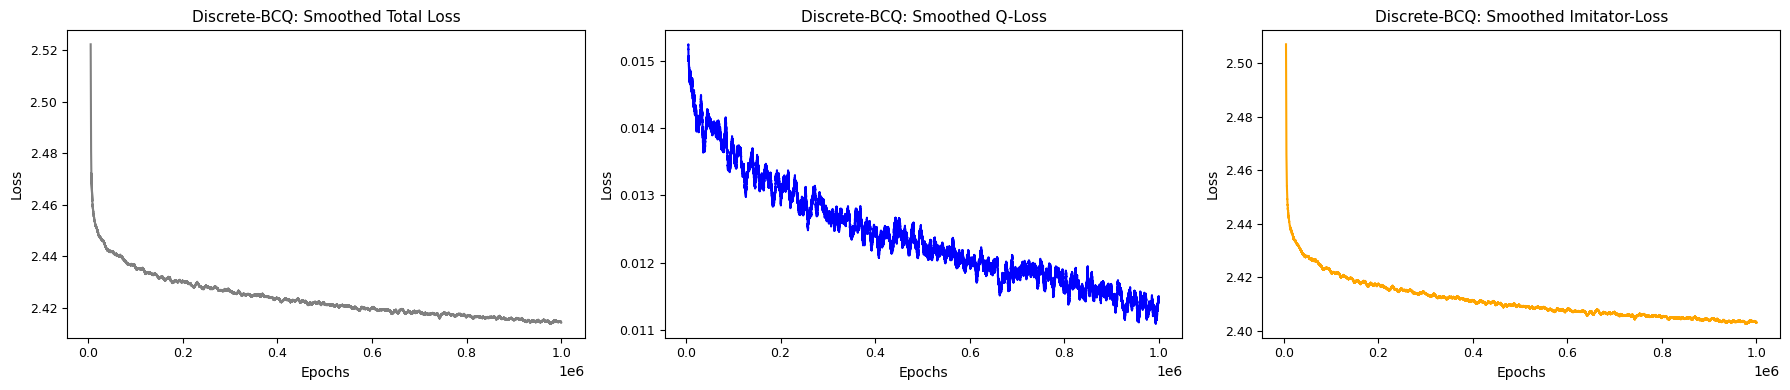

In [45]:
# Smoothing with a window size
window_size = 5000
smoothed_losses = smooth(discrete_bcq_agent.losses, window_size)
smoothed_q_losses = smooth(discrete_bcq_agent.q_losses, window_size)
smoothed_imitator_losses = smooth(discrete_bcq_agent.behavior_losses, window_size)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))  

ax1.plot(range(window_size-1, len(discrete_bcq_agent.losses)), smoothed_losses, label="Total Loss", color="gray")
ax1.set_xlabel("Epochs", size=10)
ax1.set_ylabel("Loss", size=10)
ax1.set_title("Discrete-BCQ: Smoothed Total Loss", size=11)
ax1.tick_params(labelsize=9)

ax2.plot(range(window_size-1, len(discrete_bcq_agent.q_losses)), smoothed_q_losses, label="Q-Loss", color="blue")
ax2.set_xlabel("Epochs", size=10)
ax2.set_ylabel("Loss", size=10)
ax2.set_title("Discrete-BCQ: Smoothed Q-Loss", size=11)
ax2.tick_params(labelsize=9)

ax3.plot(range(window_size-1, len(discrete_bcq_agent.behavior_losses)), smoothed_imitator_losses, label="Imitator Loss", color='orange')
ax3.set_xlabel("Epochs", size=10)
ax3.set_ylabel("Loss", size=10)
ax3.set_title("Discrete-BCQ: Smoothed Imitator-Loss", size=11)
ax3.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

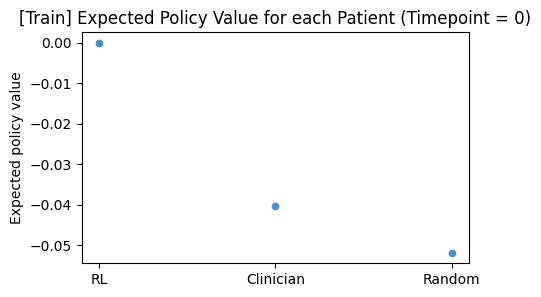

In [46]:
# evaluation on training
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_bcq_agent.q_network.eval()

for idx, row in X_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[state_columns].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

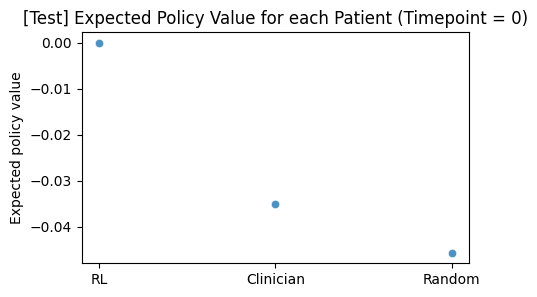

In [47]:
# evaluate for test
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_bcq_agent.q_network.eval()

for idx, row in X_test_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[state_columns].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_39647/2410654318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['action_number'] = 0
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_39647/2410654318.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['agent'] = 'RF'
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_39647/2410654318.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

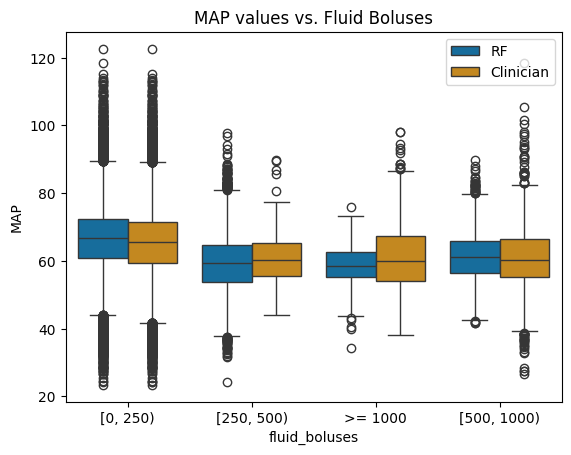

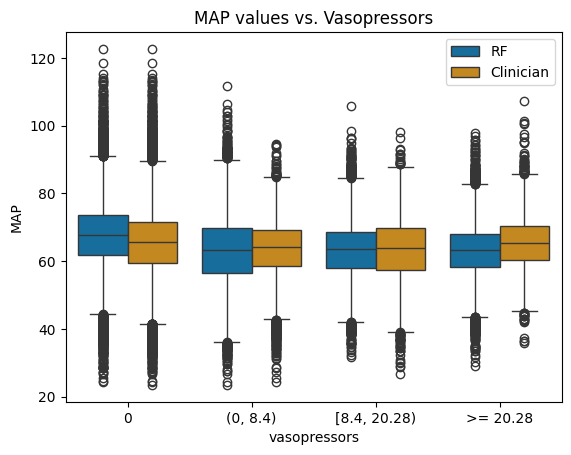

In [48]:
# MAP values for each action taken (test data)
df_boxplot_RF = test_df[['MAP']] # use the original MAP values (before scaling)
df_boxplot_RF['action_number'] = 0

for index, row in X_test_scaled.iterrows():
    state = np.array(row[state_columns].values)
    state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
    action = int(row["action_number"])
    action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

    with torch.no_grad():
        q_values = discrete_bcq_agent.q_network(state)
        rl_action = torch.argmax(q_values).item()

    df_boxplot_RF.at[index, 'action_number'] = rl_action

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = test_df[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP values vs. Fluid Boluses")
plt.show()

sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP values vs. Vasopressors")
plt.show()

---

### 3. Conservative Q-Learning

Base Model: DoubleDQN

In [51]:
class DiscreteCQL:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, alpha=0.5, target_update_freq=1000, device="mps"):
        self.gamma = gamma
        self.alpha = alpha
        self.device = device
        self.target_update_freq = target_update_freq

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)

        # copy weights to target model
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-5)

        # losses
        self.td_losses = []
        self.conservative_losses = []
        self.cql_losses = []

    def compute_loss(self, states, actions, rewards, next_states, dones):
        # 1. calculate bellman error (td error)
        # compute q-values for current states
        q_values = self.q_network(states)
        curr_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # compute next q-values using target network using action selected by current q_network (DDQN framework to reduce overestimation)
        with torch.no_grad():
            next_q_values_q_network = self.q_network(next_states)
            next_actions = next_q_values_q_network.argmax(dim=1)
            next_q_values_target = self.target_network(next_states)
            next_q_values = next_q_values_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
        
        # compute td error
        td_target = rewards + (self.gamma * next_q_values * (1 - dones))
        td_error = F.mse_loss(curr_q_values, td_target)

        # 2. conservative loss: penalize over-estimation of OOD actions
        logsumexp_q_values = torch.logsumexp(q_values, dim=1)
        conservative_loss = (logsumexp_q_values - curr_q_values).mean()

        # 3. total loss
        cql_loss = td_error + self.alpha * conservative_loss
        return cql_loss, td_error, conservative_loss
    
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # compute loss
            cql_loss, td_loss, conservative_loss = self.compute_loss(states, actions, rewards, next_states, dones)

            # optimize
            self.optimizer.zero_grad()
            cql_loss.backward()
            self.optimizer.step()

            # update target network
            if (iteration > 0) and (iteration % self.target_update_freq == 0):
                self.target_network.load_state_dict(self.q_network.state_dict())

            # store and log loss
            self.cql_losses.append(cql_loss.item())
            self.td_losses.append(td_loss.item())
            self.conservative_losses.append(conservative_loss.item())

            if (iteration > 0) and (iteration % 10000 == 0):
                avg_td_loss = sum(self.td_losses[-10000:]) / 10000
                avg_cons_loss = sum(self.conservative_losses[-10000:]) / 10000
                avg_total_loss = sum(self.cql_losses[-10000:]) / 10000
                print(f'[Step {iteration}/{num_steps}] Total Loss: {avg_total_loss:.7f}\tTD Loss: {avg_td_loss:.7f}\tConservative Loss: {avg_cons_loss:.7f}')

    def save_model(self, filepath):
        """Save the Q-network and Target-network to the specified filepath."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict()  # Optional: to save optimizer state too
        }, filepath)

    def load_model(self, filepath):
        """Load the Q-network and Target-network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        if 'optimizer' in checkpoint:
            self.optimizer.load_state_dict(checkpoint['optimizer'])

In [52]:
# train discrete cql agent
discrete_cql_agent = DiscreteCQL(state_dim=18, action_dim=16)
discrete_cql_agent.train(replay_buffer, num_steps=1000000)

[Step 10000/1000000] Total Loss: 0.9103942	TD Loss: 0.1454171	Conservative Loss: 1.5299542
[Step 20000/1000000] Total Loss: 0.7778563	TD Loss: 0.1922614	Conservative Loss: 1.1711899
[Step 30000/1000000] Total Loss: 0.7524000	TD Loss: 0.1898379	Conservative Loss: 1.1251241
[Step 40000/1000000] Total Loss: 0.7360925	TD Loss: 0.1882409	Conservative Loss: 1.0957031
[Step 50000/1000000] Total Loss: 0.7228597	TD Loss: 0.1841909	Conservative Loss: 1.0773375
[Step 60000/1000000] Total Loss: 0.7158040	TD Loss: 0.1842729	Conservative Loss: 1.0630622
[Step 70000/1000000] Total Loss: 0.7108368	TD Loss: 0.1831546	Conservative Loss: 1.0553643
[Step 80000/1000000] Total Loss: 0.7045878	TD Loss: 0.1825427	Conservative Loss: 1.0440903
[Step 90000/1000000] Total Loss: 0.6928806	TD Loss: 0.1782081	Conservative Loss: 1.0293449
[Step 100000/1000000] Total Loss: 0.6885195	TD Loss: 0.1776224	Conservative Loss: 1.0217941
[Step 110000/1000000] Total Loss: 0.6812195	TD Loss: 0.1757087	Conservative Loss: 1.01102

In [53]:
# save model
torch.save(discrete_cql_agent, "DiscreteCQL/cql_agent.pth")
discrete_cql_agent.save_model(filepath="DiscreteCQL/models.pth")

Evaluation:

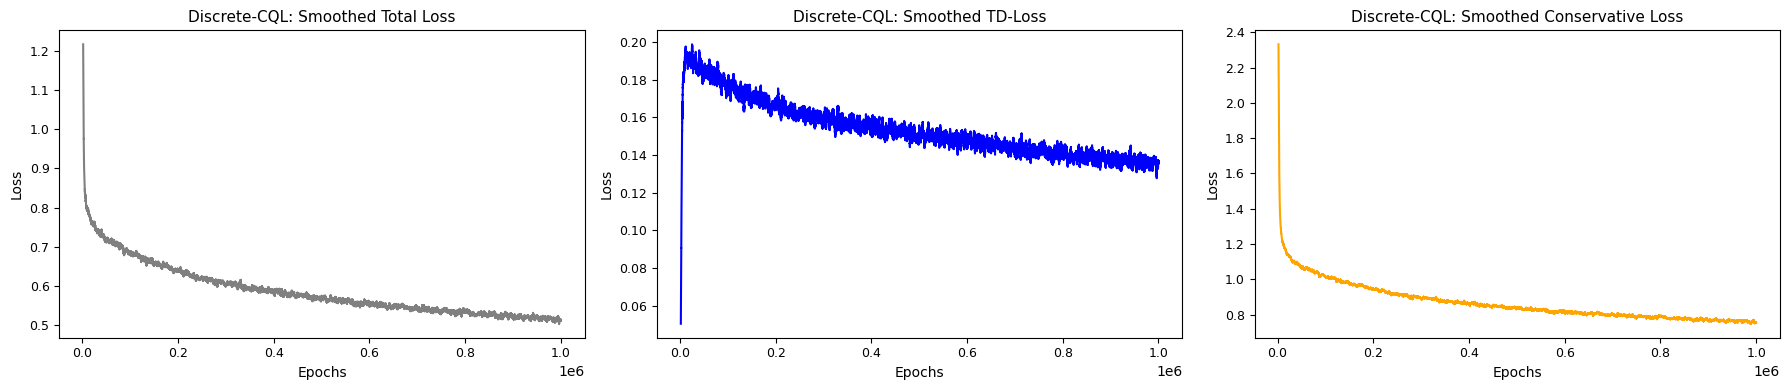

In [54]:
# Smoothing with a window size of 5000
window_size = 2000
smoothed_losses = smooth(discrete_cql_agent.cql_losses, window_size)
smoothed_td_losses = smooth(discrete_cql_agent.td_losses, window_size)
smoothed_cons_losses = smooth(discrete_cql_agent.conservative_losses, window_size)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))  

ax1.plot(range(window_size-1, len(discrete_cql_agent.cql_losses)), smoothed_losses, label="Total Loss", color="gray")
ax1.set_xlabel("Epochs", size=10)
ax1.set_ylabel("Loss", size=10)
ax1.set_title("Discrete-CQL: Smoothed Total Loss", size=11)
ax1.tick_params(labelsize=9)

ax2.plot(range(window_size-1, len(discrete_cql_agent.td_losses)), smoothed_td_losses, label="TD Loss", color="blue")
ax2.set_xlabel("Epochs", size=10)
ax2.set_ylabel("Loss", size=10)
ax2.set_title("Discrete-CQL: Smoothed TD-Loss", size=11)
ax2.tick_params(labelsize=9)

ax3.plot(range(window_size-1, len(discrete_cql_agent.conservative_losses)), smoothed_cons_losses, label="Conservative Loss", color='orange')
ax3.set_xlabel("Epochs", size=10)
ax3.set_ylabel("Loss", size=10)
ax3.set_title("Discrete-CQL: Smoothed Conservative Loss", size=11)
ax3.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

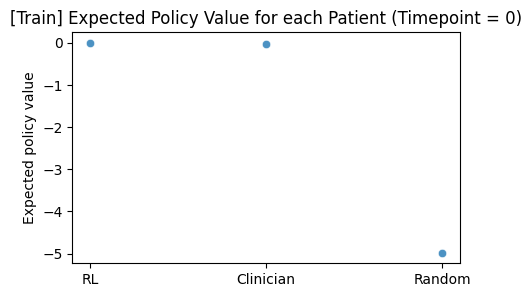

In [55]:
# evaluation on training
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_cql_agent.q_network.eval()

for idx, row in X_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[state_columns].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_cql_agent.device)

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

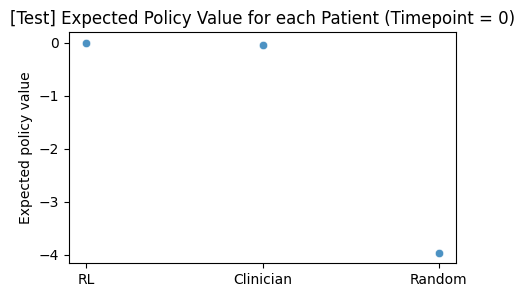

In [56]:
# evaluate for test
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_cql_agent.q_network.eval()

for idx, row in X_test_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[state_columns].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_cql_agent.device)

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

In [64]:
# MAP values for each action taken (test data)
df_boxplot_CQL = test_df[['MAP']]
df_boxplot_CQL['action_number'] = 0
df_boxplot_BCQ = test_df[["MAP"]]
df_boxplot_BCQ['action_number'] = 0

for index, row in X_test_scaled.iterrows():
    state = np.array(row[state_columns].values)
    state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
    action = int(row["action_number"])
    action = torch.LongTensor([action]).to(discrete_cql_agent.device)

    with torch.no_grad():
        q_values_cql = discrete_cql_agent.q_network(state)
        cql_action = torch.argmax(q_values_cql).item()

        q_values_bcq = discrete_bcq_agent.q_network(state)
        bcq_action = torch.argmax(q_values_bcq).item()

    df_boxplot_CQL.at[index, 'action_number'] = cql_action
    df_boxplot_BCQ.at[index, 'action_number'] = bcq_action

df_boxplot_CQL['agent'] = 'CQL'
df_boxplot_BCQ['agent'] = 'BCQ'
df_boxplot_clinician = test_df[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_CQL, df_boxplot_BCQ, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

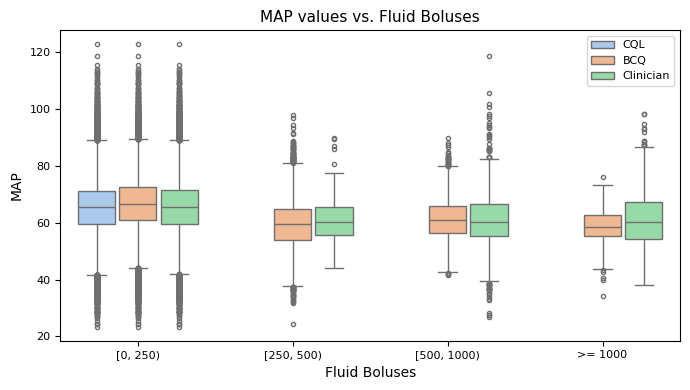

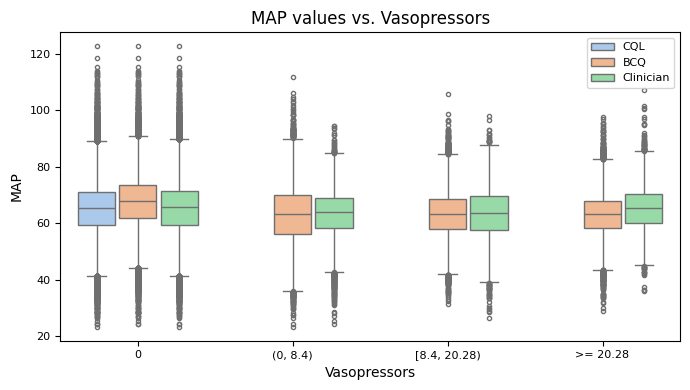

In [70]:
# plot MAP against actions
plt.figure(figsize=(7, 4))
sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="pastel", hue='agent', gap=.1, fliersize=3, order=['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000'])
plt.legend(loc="upper right", prop={'size': 8})
plt.title("MAP values vs. Fluid Boluses", size=11)
plt.xlabel("Fluid Boluses", size=10)
plt.ylabel("MAP", size=10)
plt.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="pastel", hue='agent', gap=.1, fliersize=3, order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right", prop={'size': 8})
plt.title("MAP values vs. Vasopressors")
plt.xlabel("Vasopressors", size=10)
plt.ylabel("MAP", size=10)
plt.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

___

### Evaluation

Load the models:

In [57]:
# Discrete BCQ
discrete_bcq_agent = DiscreteBCQ(state_dim=18, action_dim=16)
discrete_bcq_agent.load_model("DiscreteBCQ/models.pth")

# Discrete CQL
discrete_cql_agent = DiscreteCQL(state_dim=18, action_dim=16)
discrete_cql_agent.load_model("DiscreteCQL/models.pth")

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_33461/3184637452.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_locat

Evaluation metrics:

1. Off-Policy Evaluation: Estimate the performance of a policy without interacting with the environment. 

    * **Weighted Importance Sampling**: Calculate the expected reward using a weighted sum of observed rewards, with the weights based on how likely the actions taken by the clinician are under the learned policy. Good performance on WIS suggests that the policy performs well in regions of the state-action space where the clinician policy overlaps with your learned policy.

2. **Policy Value Estimation**: Estimate the expected return (cumulative rewards) of each policy using offline data. Since you have trained on historical data, this gives an idea of how well the policies would perform if deployed. If one model consistently has a higher estimated policy value, it indicates that it may provide better clinical outcomes.

3. **Action Alignment with Clinician**: Comparing the actions taken by each model with those taken by clinicians gives insight into how much the models diverge from clinical practice. A high alignment suggests the model is conservative and safe, while divergence might indicate novel, potentially riskier strategies.

4. **Statistical Testing**: Use statistical tests to assess if differences between the clinician policy and learned policies are significant. For example, a paired t-test or Mann-Whitney U test could be used to compare the rewards associated with each policy. If the learned policies significantly outperform or match the clinician policy, they may represent viable alternatives for decision-making.

5. **Out-of-Distribution (OOD) Performance**: Given that BCQ and CQL are designed to handle OOD states, evaluating their robustness in unseen situations is crucial. This could involve identifying specific patient groups or states that were underrepresented in the training data and checking performance. Robust policies that maintain good performance in OOD states are more suitable for deployment in real-world scenarios with varied patient populations.

6. **Explainability and Action Diversity**: Since CQL penalizes overestimation and BCQ is designed to mimic human actions, you can check how much each policy explores and diverges from typical clinician decisions. Plot the action distribution to visualize where the policies align with or diverge from clinician behavior. If a model explores too much, it may risk patient safety, while low exploration might indicate conservativeness.



---

**1. Weighted Importance Sampling**

For WIS, we need to train a clinician policy to estimate the clinician's action probabilities. This is necessary because we often do not have access to the true clinician action distribution.

Then, we reweight the offline data to simulate how the learned policy would have performed, even though the data was collected using the clinician’s policy. This is crucial for policy evaluation in offline settings where we cannot interact with the environment. Using weighted importance sampling helps reduce the variance of standard importance sampling, which can be high if the evaluation policy differs significantly from the clinician policy. It gives you a more stable estimate of the policy’s value.

In [72]:
# BCQ for discrete actions
class ClinicianAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, device="mps"):
        self.gamma = gamma
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.device = device
        self.network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=1e-4)
        self.losses = []
    
    def save_model(self, filepath):
        """Save the network to the specified filepath."""
        torch.save({
            'network': self.network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, filepath)

    def load_model(self, filepath):
        """Load the network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.network.load_state_dict(checkpoint['network'])
        if 'optimizer' in checkpoint:
            self.optimizer.load_state_dict(checkpoint['optimizer'])
              
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # behavior cloning (cross-entropy loss with one-hot actions)
            logits = self.network(states)
            log_probs = F.log_softmax(logits, dim=1)
            loss = F.nll_loss(log_probs, actions)

            # update behavior model
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # store loss
            self.losses.append(loss.item())

            if (iteration > 0) and (iteration % 10000 == 0):
                avg_loss = sum(self.losses[-10000:]) / 10000
                print(f'[Step {iteration}/{num_steps}] Loss: {avg_loss:.8f}')

In [73]:
# train clinician policy
clinician_agent = ClinicianAgent(state_dim=18, action_dim=16, hidden_dim=128)
clinician_agent.train(replay_buffer, num_steps=800000)

[Step 10000/800000] Loss: 0.67526000
[Step 20000/800000] Loss: 0.58777906
[Step 30000/800000] Loss: 0.56107257
[Step 40000/800000] Loss: 0.54067303
[Step 50000/800000] Loss: 0.53145554
[Step 60000/800000] Loss: 0.51986477
[Step 70000/800000] Loss: 0.51233382
[Step 80000/800000] Loss: 0.50672703
[Step 90000/800000] Loss: 0.49967357
[Step 100000/800000] Loss: 0.49122374
[Step 110000/800000] Loss: 0.48532819
[Step 120000/800000] Loss: 0.48094182
[Step 130000/800000] Loss: 0.47888378
[Step 140000/800000] Loss: 0.47152965
[Step 150000/800000] Loss: 0.46989470
[Step 160000/800000] Loss: 0.46706904
[Step 170000/800000] Loss: 0.46080630
[Step 180000/800000] Loss: 0.45441905
[Step 190000/800000] Loss: 0.45236539
[Step 200000/800000] Loss: 0.44556877
[Step 210000/800000] Loss: 0.44458093
[Step 220000/800000] Loss: 0.44013792
[Step 230000/800000] Loss: 0.43787892
[Step 240000/800000] Loss: 0.43496353
[Step 250000/800000] Loss: 0.43480045
[Step 260000/800000] Loss: 0.43012127
[Step 270000/800000] 

In [74]:
clinician_agent.train(replay_buffer, num_steps=200000)

[Step 10000/200000] Loss: 0.35836874
[Step 20000/200000] Loss: 0.35516451
[Step 30000/200000] Loss: 0.35581187
[Step 40000/200000] Loss: 0.35762744
[Step 50000/200000] Loss: 0.35483156
[Step 60000/200000] Loss: 0.35372760
[Step 70000/200000] Loss: 0.35158189
[Step 80000/200000] Loss: 0.35415485
[Step 90000/200000] Loss: 0.35005886
[Step 100000/200000] Loss: 0.35175459
[Step 110000/200000] Loss: 0.34941019
[Step 120000/200000] Loss: 0.35095339
[Step 130000/200000] Loss: 0.35023881
[Step 140000/200000] Loss: 0.34839743
[Step 150000/200000] Loss: 0.34608568
[Step 160000/200000] Loss: 0.34428615
[Step 170000/200000] Loss: 0.34717668
[Step 180000/200000] Loss: 0.34488432
[Step 190000/200000] Loss: 0.34545706


Save the clinician policy:

In [75]:
# save model
torch.save(clinician_agent, "Clinician/agent.pth")
clinician_agent.save_model(filepath="Clinician/model.pth")

Weighted Importance Sampling:

In [83]:
# load agent
clinician_agent = ClinicianAgent(state_dim=18, action_dim=16, hidden_dim=128)
clinician_agent.load_model(filepath="Clinician/model.pth")

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_33461/3383097341.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_locati

In [86]:
def get_policy_probs(network, states):
    with torch.no_grad():
        q_values = network(states)
        probs = F.softmax(q_values, dim=1).cpu().numpy()
    return probs

def weighted_importance_sampling(policy_network, state, action, reward):
    """Compute weighted importance sampling for policy evaluation"""
    # get probabilities of the actions that were actually taken
    policy_probs = get_policy_probs(policy_network, state.unsqueeze(0))
    policy_action_probs = policy_probs[0, action]

    # assume action taken by the clinician to be rather deterministic 
    # In purely offline settings where no new clinician behavior is available, 
    # treating the observed clinician action as having a probability of 1 can reduce errors that 
    # might arise from an imperfect approximation model for the clinician’s policy. 
    # The alternative—learning a probabilistic clinician model—can sometimes introduce noise, 
    # especially if the offline dataset does not sufficiently capture clinician action patterns.
    # use a smoothed or soft probability instead of setting is as 1.0. 
    clinician_action_probs = 0.95

    # compute importance weights
    importance_weights = policy_action_probs / clinician_action_probs

    # weighted sum of rewards
    weighted_rewards = importance_weights * reward
    return weighted_rewards

def compute_wis_for_trajectory(df, learned_policy, gamma=0.99):
    clinician_rewards = []
    policy_rewards = []

    unique_patients = list(df["id"].unique())
    for id in unique_patients:
        patient_clinician_reward = 0
        patient_policy_reward = 0

        # get the rows for the patient
        patient_df = df[df["id"]==id].reset_index(drop=True)
        
        for i, row in patient_df.iterrows():
            hour = row["hour"]

            # ignore last hour (since reward for last timepoint is captured by 46)
            if hour == 47:
                continue
            reward = row["reward"]
            action = torch.tensor(row["action_number"]).long()
            state = torch.tensor(row[state_columns].values).float().to('mps')
            wis_estimate = weighted_importance_sampling(learned_policy, state, action, reward)

            patient_clinician_reward += (gamma ** hour) * reward
            patient_policy_reward += (gamma ** hour) * wis_estimate
        
        clinician_rewards.append(patient_clinician_reward)
        policy_rewards.append(patient_policy_reward)
    
    avg_clinician_rewards = sum(clinician_rewards) / len(clinician_rewards)
    avg_policy_rewards = sum(policy_rewards) / len(policy_rewards)
    return avg_clinician_rewards, avg_policy_rewards, clinician_rewards, policy_rewards


In [87]:
# get expected cumulative rewards
avg_clinician_rewards, avg_bcq_rewards, clinician_rewards, bcq_rewards = compute_wis_for_trajectory(X_test_scaled, discrete_bcq_agent.q_network)
_, avg_cql_rewards, _, cql_rewards = compute_wis_for_trajectory(X_test_scaled, discrete_cql_agent.q_network)

print(f'Expected cumulative reward for Clinician Policy: {avg_clinician_rewards}')
print(f'Expected cumulative reward for Discrete BCQ Policy: {avg_bcq_rewards}')
print(f'Expected cumulative reward for Discrete CQL Policy: {avg_cql_rewards}')

Expected cumulative reward for Clinician Policy: -2.2177193162803364
Expected cumulative reward for Discrete BCQ Policy: -0.14000226495631526
Expected cumulative reward for Discrete CQL Policy: -1.1808682252114644


In [88]:
from scipy.stats import ttest_rel

# Conduct a paired t-test to compare rewards of learned policies and clinician actions
_, p_value_bcq = ttest_rel(bcq_rewards, clinician_rewards)
_, p_value_cql = ttest_rel(cql_rewards, clinician_rewards)

# Interpret the p-value: 
if p_value_bcq < 0.05:
    print("BCQ policy significantly differs from clinician policy")
else:
    print("BCQ policy does not significantly differ from clinician policy")

if p_value_cql < 0.05:
    print("CQL policy significantly differs from clinician policy")
else:
    print("CQL policy does not significantly differ from clinician policy")

BCQ policy significantly differs from clinician policy
CQL policy significantly differs from clinician policy


**2. Action Alignment with Clinician Actions**

In [89]:
def get_policy_actions(policy_network, states):
    """Get the actions predicted by the policy"""
    with torch.no_grad():
        q_values =policy_network(states)

    policy_actions = torch.argmax(q_values, dim=1)
    return policy_actions

def action_alignment(policy_network, states, actions):
    policy_actions = get_policy_actions(policy_network, states)
    alignment = (policy_actions == actions).sum().item() / len(actions)
    return alignment * 100

In [90]:
# check alignment
states = torch.tensor(X_test_scaled[state_columns].values).float().to("mps")
actions = torch.tensor(X_test_scaled["action_number"].values).long().to("mps")
bcq_alignment = action_alignment(discrete_bcq_agent.q_network, states, actions)
cql_alignment = action_alignment(discrete_cql_agent.q_network, states, actions)

print(f"Actions Matched for Discrete BCQ Policy: {bcq_alignment}")
print(f"Actions Matched for Discrete CQL Policy: {cql_alignment}")

Actions Matched for Discrete BCQ Policy: 37.527808676307004
Actions Matched for Discrete CQL Policy: 82.60683166481274


In [91]:
# Function to decode actions to fluid boluses and vasopressors
def decode_action(action):
    fluid = fluid_boluses_dict[action]
    vasopressor = vasopressors_dict[action]
    return fluid, vasopressor

def get_clinician_action_distribution(clinician_actions):
    """Compute the decoded action distribution for clinician actions."""
    # Initialize count matrix
    fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']  # Sorted fluid boluses
    vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']  # Sorted vasopressors
    action_count_matrix = np.zeros((len(vasopressor_categories), len(fluid_categories)))

    # Count the occurrences of each fluid-vasopressor combination
    for action in clinician_actions:
        fluid, vasopressor = decode_action(action)  # Use the same decode_action function
        fluid_idx = fluid_categories.index(fluid)
        vasopressor_idx = vasopressor_categories.index(vasopressor)
        action_count_matrix[vasopressor_idx, fluid_idx] += 1

    # Normalize to get a probability distribution
    action_distribution = action_count_matrix / len(clinician_actions)
    return action_distribution, fluid_categories, vasopressor_categories

def get_action_distribution(policy_network, states):
    """Compute the decoded action distribution for the given policy network."""
    with torch.no_grad():
        q_values = policy_network(states)
    
    predicted_actions = torch.argmax(q_values, dim=1).cpu().numpy()
    
    # Initialize count matrix
    fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']  # Sorted fluid boluses
    vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']  # Sorted vasopressors
    action_count_matrix = np.zeros((len(vasopressor_categories), len(fluid_categories)))

    # Count the occurrences of each fluid-vasopressor combination
    for action in predicted_actions:
        fluid, vasopressor = decode_action(action)
        fluid_idx = fluid_categories.index(fluid)
        vasopressor_idx = vasopressor_categories.index(vasopressor)
        action_count_matrix[vasopressor_idx, fluid_idx] += 1

    # Normalize to get a probability distribution
    action_distribution = action_count_matrix / len(predicted_actions)
    
    return action_distribution, fluid_categories, vasopressor_categories

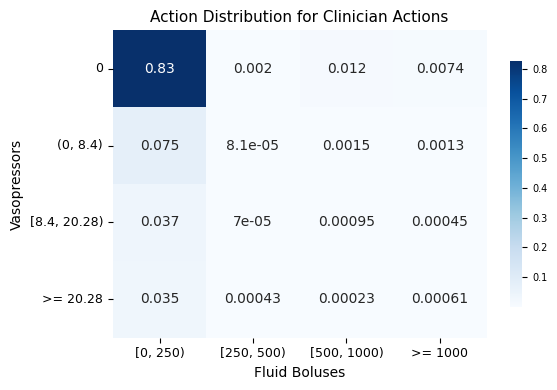

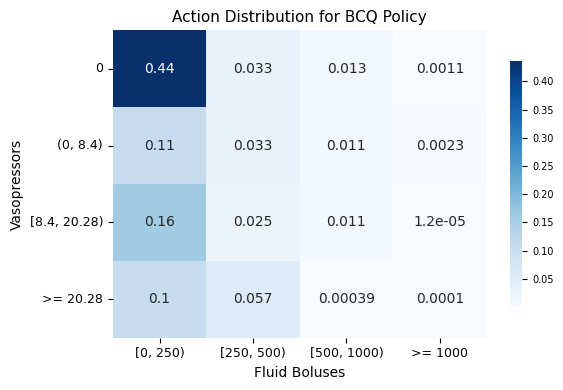

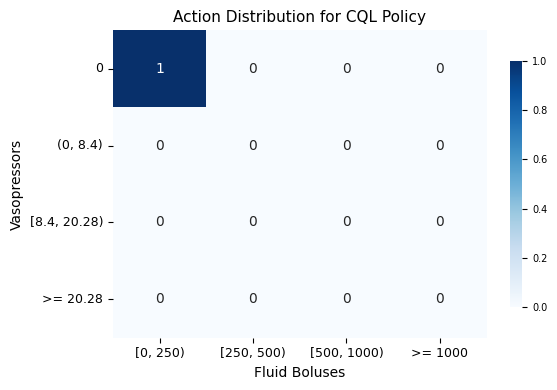

In [94]:
action_distribution_clinician, fluid_categories, vasopressor_categories = get_clinician_action_distribution(np.array(actions.cpu()))
action_distribution_bcq, fluid_categories, vasopressor_categories = get_action_distribution(discrete_bcq_agent.q_network, states)
action_distribution_cql, _, _ = get_action_distribution(discrete_cql_agent.q_network, states)

# Plot the action distribution 
plt.figure(figsize=(6, 4))
sns.heatmap(action_distribution_clinician, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories, cbar_kws={'shrink': 0.8})
plt.title('Action Distribution for Clinician Actions', fontsize=11)
plt.xlabel('Fluid Boluses', fontsize=10)
plt.ylabel('Vasopressors', fontsize=10)
plt.yticks(rotation=0)
plt.tick_params(labelsize=9)
cbar = plt.gca().collections[0].colorbar  # Get color bar
cbar.ax.tick_params(labelsize=7)  # Adjust color bar label size
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(action_distribution_bcq, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories, cbar_kws={'shrink': 0.8})
plt.title('Action Distribution for BCQ Policy', fontsize=11)
plt.xlabel('Fluid Boluses', fontsize=10)
plt.ylabel('Vasopressors', fontsize=10)
plt.yticks(rotation=0)
plt.tick_params(labelsize=9)
cbar = plt.gca().collections[0].colorbar  # Get color bar
cbar.ax.tick_params(labelsize=7)  # Adjust color bar label size

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(action_distribution_cql, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories, cbar_kws={'shrink': 0.8})
plt.title('Action Distribution for CQL Policy', fontsize=11)
plt.xlabel('Fluid Boluses', fontsize=10)
plt.ylabel('Vasopressors', fontsize=10)
plt.yticks(rotation=0)
plt.tick_params(labelsize=9)
cbar = plt.gca().collections[0].colorbar  # Get color bar
cbar.ax.tick_params(labelsize=7)  # Adjust color bar label size

plt.tight_layout()
plt.show()

**Distribution of Q-Values**

In [95]:
q_values_dist = pd.DataFrame(columns=["id", "hour", "clinician", "bcq"])
discrete_bcq_agent.q_network.eval()

for _, row in X_test_scaled.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            bcq_q_value = torch.max(q_values).item()

            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()

        q_values_dist.loc[len(q_values_dist)] = [row["id"], row["hour"], clinician_q_value, bcq_q_value]

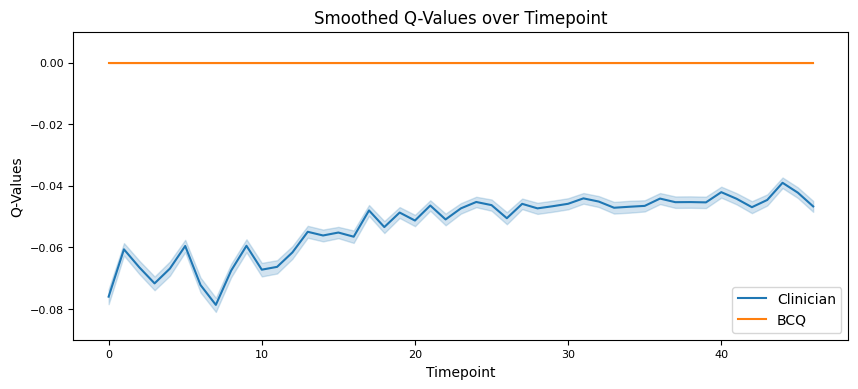

In [108]:
# plot 
plt.figure(figsize=(10, 4))
sns.lineplot(x="hour", y="clinician", data=q_values_dist, errorbar="se", legend=None)
sns.lineplot(x="hour", y="bcq", data=q_values_dist, errorbar="se", legend=None)
plt.title("Smoothed Q-Values over Timepoint", fontsize=12)
plt.xlabel("Timepoint", fontsize=10)
plt.ylabel("Q-Values", fontsize=10)
plt.tick_params(labelsize=8)
plt.ylim([-0.09, 0.01])
plt.legend(handles=[plt.Line2D([0], [0], color=sns.color_palette()[0], label='Clinician'),
                    plt.Line2D([0], [0], color=sns.color_palette()[1], label='BCQ')],
           loc="lower right")
plt.show()

In [109]:
q_values_dist = pd.DataFrame(columns=["id", "hour", "clinician", "cql"])
discrete_cql_agent.q_network.eval()

for _, row in X_test_scaled.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            cql_q_value = torch.max(q_values).item()

            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()

        q_values_dist.loc[len(q_values_dist)] = [row["id"], row["hour"], clinician_q_value, cql_q_value]

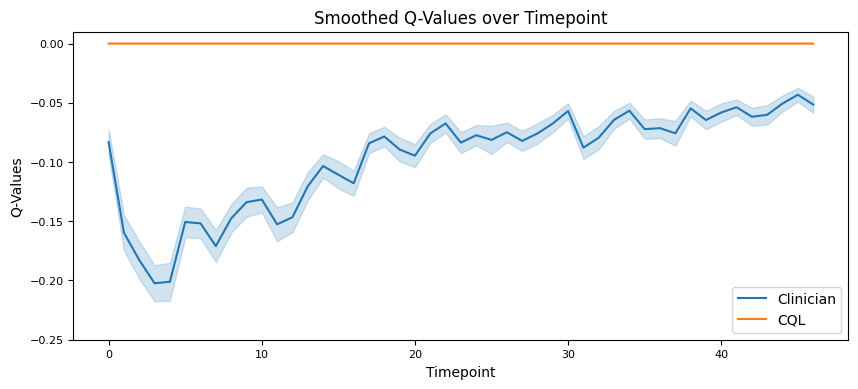

In [114]:
# plot 
plt.figure(figsize=(10, 4))
sns.lineplot(x="hour", y="clinician", data=q_values_dist, errorbar="se", legend=None)
sns.lineplot(x="hour", y="cql", data=q_values_dist, errorbar="se", legend=None)
plt.title("Smoothed Q-Values over Timepoint", fontsize=12)
plt.xlabel("Timepoint", fontsize=10)
plt.ylabel("Q-Values", fontsize=10)
plt.tick_params(labelsize=8)
plt.ylim([-0.25, 0.01])
plt.legend(handles=[plt.Line2D([0], [0], color=sns.color_palette()[0], label='Clinician'),
                    plt.Line2D([0], [0], color=sns.color_palette()[1], label='CQL')],
           loc="lower right")
plt.show()

**3. Identify and Compare performance on OOD States**

In [115]:
import numpy as np

def fit_mahalanobis(training_states):
    # Compute the mean and covariance of the training data
    mean_vector = np.mean(training_states, axis=0)
    cov_matrix = np.cov(training_states, rowvar=False)
    
    # Invert the covariance matrix for Mahalanobis calculation
    cov_matrix_inv = np.linalg.inv(cov_matrix)
    
    return mean_vector, cov_matrix_inv

def calculate_mahalanobis_distance(test_states, mean_vector, cov_matrix_inv):
    distances = []
    for state in test_states:
        diff = state - mean_vector
        distance = np.sqrt(np.dot(np.dot(diff.T, cov_matrix_inv), diff))
        distances.append(distance)
    return np.array(distances)

def identify_ood_states(test_states, training_states, threshold=None):
    # Fit Mahalanobis model
    mean_vector, cov_matrix_inv = fit_mahalanobis(training_states)
    
    # Calculate distances
    distances = calculate_mahalanobis_distance(test_states, mean_vector, cov_matrix_inv)
    
    # Determine threshold if not provided
    if threshold is None:
        # Set threshold as, for example, the 95th percentile of training distances
        train_distances = calculate_mahalanobis_distance(training_states, mean_vector, cov_matrix_inv)
        threshold = np.percentile(train_distances, 95)
    
    # Identify OOD states
    ood_indices = np.where(distances > threshold)[0]
    ood_states = test_states[ood_indices]
    
    return ood_states, ood_indices

In [116]:
# get the states for training and test
training_states = []
for _, row in X_scaled.iterrows():
    if row["hour"] == 47:
        continue
    state = np.array(row[state_columns].values)
    training_states.append(state)

test_states = []
for _, row in X_test_scaled.iterrows():
    if row["hour"] == 47:
        continue
    state = np.array(row[state_columns].values)
    test_states.append(state)

training_states = np.array(training_states)
test_states = np.array(test_states)

In [117]:
# get ood states
ood_states, ood_indices = identify_ood_states(test_states, training_states)

In [118]:
# get the data 
X_test_ood = pd.DataFrame(columns=X_test_scaled.columns)
for i, row in X_test_scaled.iterrows():
    if i in ood_indices:
        X_test_ood.loc[len(X_test_ood)] = row

In [119]:
# check alignment
ood_states = torch.tensor(X_test_ood[state_columns].values).float().to("mps")
ood_actions = torch.tensor(X_test_ood["action_number"].values).long().to("mps")
bcq_alignment = action_alignment(discrete_bcq_agent.q_network, ood_states, ood_actions)
cql_alignment = action_alignment(discrete_cql_agent.q_network, ood_states, ood_actions)

print(f"Actions Matched for Discrete BCQ Policy: {bcq_alignment}")
print(f"Actions Matched for Discrete CQL Policy: {cql_alignment}")

Actions Matched for Discrete BCQ Policy: 38.67658373942036
Actions Matched for Discrete CQL Policy: 83.61118235444987


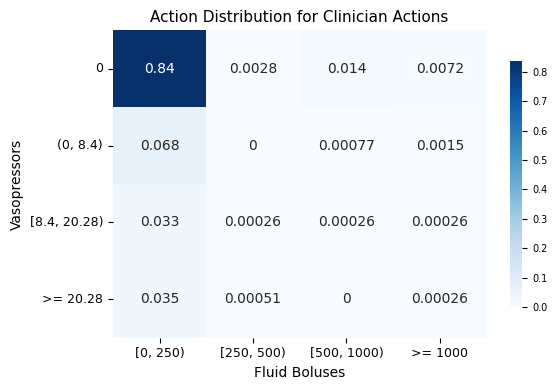

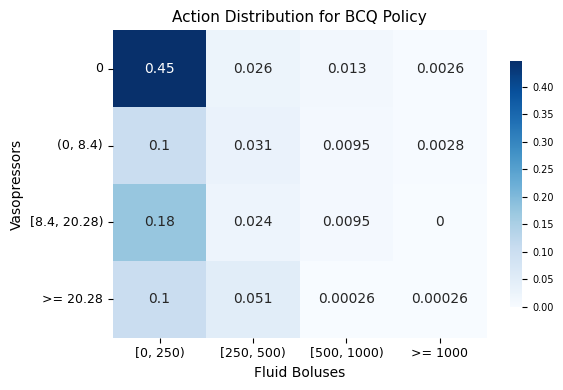

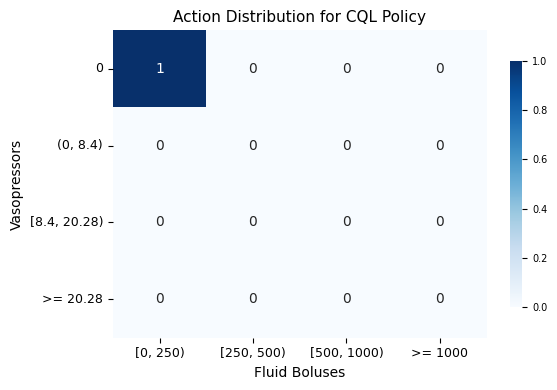

In [120]:
# compare performance
action_distribution_clinician, fluid_categories, vasopressor_categories = get_clinician_action_distribution(np.array(ood_actions.cpu()))
action_distribution_bcq, fluid_categories, vasopressor_categories = get_action_distribution(discrete_bcq_agent.q_network, ood_states)
action_distribution_cql, _, _ = get_action_distribution(discrete_cql_agent.q_network, ood_states)

# Plot the action distribution 
plt.figure(figsize=(6, 4))
sns.heatmap(action_distribution_clinician, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories, cbar_kws={'shrink': 0.8})
plt.title('Action Distribution for Clinician Actions', fontsize=11)
plt.xlabel('Fluid Boluses', fontsize=10)
plt.ylabel('Vasopressors', fontsize=10)
plt.yticks(rotation=0)
plt.tick_params(labelsize=9)
cbar = plt.gca().collections[0].colorbar 
cbar.ax.tick_params(labelsize=7) 
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(action_distribution_bcq, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories, cbar_kws={'shrink': 0.8})
plt.title('Action Distribution for BCQ Policy', fontsize=11)
plt.xlabel('Fluid Boluses', fontsize=10)
plt.ylabel('Vasopressors', fontsize=10)
plt.yticks(rotation=0)
plt.tick_params(labelsize=9)
cbar = plt.gca().collections[0].colorbar 
cbar.ax.tick_params(labelsize=7) 
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(action_distribution_cql, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories, cbar_kws={'shrink': 0.8})
plt.title('Action Distribution for CQL Policy', fontsize=11)
plt.xlabel('Fluid Boluses', fontsize=10)
plt.ylabel('Vasopressors', fontsize=10)
plt.yticks(rotation=0)
plt.tick_params(labelsize=9)
cbar = plt.gca().collections[0].colorbar 
cbar.ax.tick_params(labelsize=7) 
plt.tight_layout()
plt.show()

Compare q-values:

In [121]:
q_values_dist = pd.DataFrame(columns=["id", "hour", "clinician", "bcq"])
discrete_bcq_agent.q_network.eval()

for _, row in X_test_ood.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            bcq_q_value = torch.max(q_values).item()

            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()

        q_values_dist.loc[len(q_values_dist)] = [row["id"], row["hour"], clinician_q_value, bcq_q_value]

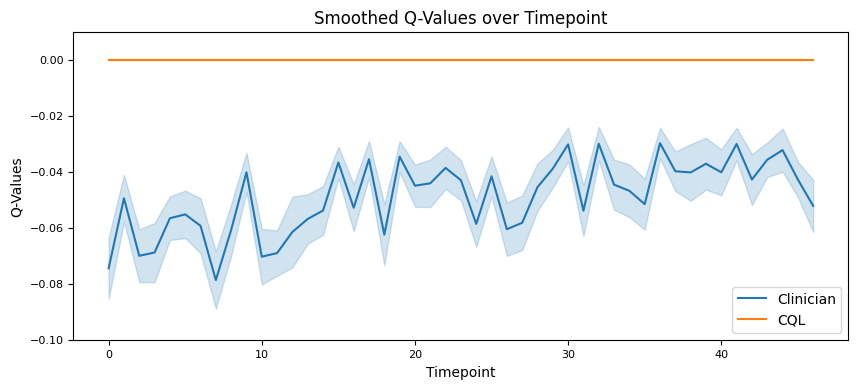

In [124]:
# plot 
plt.figure(figsize=(10, 4))
sns.lineplot(x="hour", y="clinician", data=q_values_dist, errorbar="se", legend=None)
sns.lineplot(x="hour", y="bcq", data=q_values_dist, errorbar="se", legend=None)
plt.title("Smoothed Q-Values over Timepoint", fontsize=12)
plt.xlabel("Timepoint", fontsize=10)
plt.ylabel("Q-Values", fontsize=10)
plt.tick_params(labelsize=8)
plt.ylim([-0.10, 0.01])
plt.legend(handles=[plt.Line2D([0], [0], color=sns.color_palette()[0], label='Clinician'),
                    plt.Line2D([0], [0], color=sns.color_palette()[1], label='CQL')],
           loc="lower right")
plt.show()

In [125]:
q_values_dist = pd.DataFrame(columns=["id", "hour", "clinician", "cql"])
discrete_cql_agent.q_network.eval()

for _, row in X_test_ood.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            cql_q_value = torch.max(q_values).item()

            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()

        q_values_dist.loc[len(q_values_dist)] = [row["id"], row["hour"], clinician_q_value, cql_q_value]

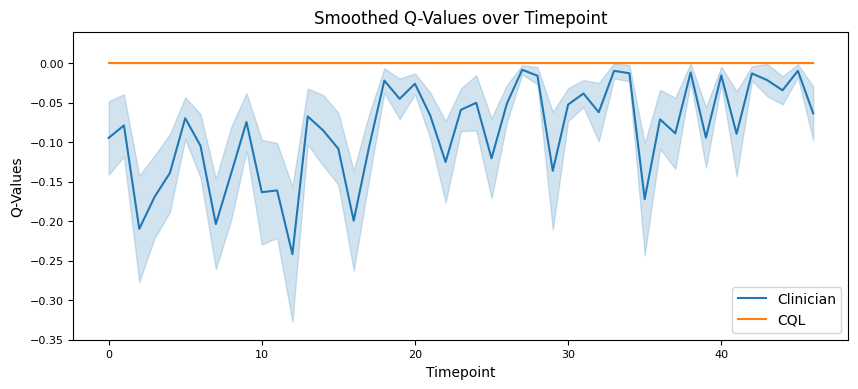

In [129]:
# plot 
plt.figure(figsize=(10, 4))
sns.lineplot(x="hour", y="clinician", data=q_values_dist, errorbar="se", legend=None)
sns.lineplot(x="hour", y="cql", data=q_values_dist, errorbar="se", legend=None)
plt.title("Smoothed Q-Values over Timepoint", fontsize=12)
plt.xlabel("Timepoint", fontsize=10)
plt.ylabel("Q-Values", fontsize=10)
plt.tick_params(labelsize=8)
plt.ylim([-0.35, 0.04])
plt.legend(handles=[plt.Line2D([0], [0], color=sns.color_palette()[0], label='Clinician'),
                    plt.Line2D([0], [0], color=sns.color_palette()[1], label='CQL')],
           loc="lower right")
plt.show()

Compare the actions taken at different MAP values:

In [130]:
def categorize_map(row):
    if row.MAP > 65:
        return ">65"
    elif row.MAP > 60:
        return "60-65"
    elif row.MAP > 55:
        return "55-60"
    else:
        return "<55"

# Apply this to the dataset
test_df['MAP_tier'] = test_df.apply(categorize_map, axis=1)

In [131]:
# apply to scaled test
X_test_scaled['MAP_tier'] = np.array(test_df['MAP_tier'])

In [132]:
# get the predicted action 
def get_action(policy_network, states):
    """Compute the decoded action distribution for the given policy network."""
    with torch.no_grad():
        q_values = policy_network(states)
    
    predicted_actions = torch.argmax(q_values, dim=1).cpu().numpy()
    predicted_fluids = []
    predicted_vasopressors = []
    for action in predicted_actions:
        fluid, vasopressor = decode_action(action)
        predicted_fluids.append(fluid)
        predicted_vasopressors.append(vasopressor)
    
    return np.array(predicted_fluids), np.array(predicted_vasopressors)

In [133]:
# get the actions
bcq_fluids, bcq_vasopressors = get_action(discrete_bcq_agent.q_network, states)
cql_fluids, cql_vasopressors = get_action(discrete_cql_agent.q_network, states)

X_test_copy = X_test_scaled.copy()
X_test_copy["bcq_fluid"] = bcq_fluids
X_test_copy["bcq_vasopressor"] = bcq_vasopressors
X_test_copy["cql_fluid"] = cql_fluids
X_test_copy["cql_vasopressor"] = cql_vasopressors
X_test_copy['clinician_fluid'], X_test_copy['clinician_vasopressor'] = zip(*X_test_copy['action_number'].map(decode_action))

In [134]:
# group by MAP tier and action type
bcq_action_counts = X_test_copy.groupby(["MAP_tier", "bcq_fluid", "bcq_vasopressor"]).size().reset_index(name="bcq_count")
cql_action_counts = X_test_copy.groupby(["MAP_tier", "cql_fluid", "cql_vasopressor"]).size().reset_index(name="cql_count")
clinician_action_counts = X_test_copy.groupby(["MAP_tier", "clinician_fluid", "clinician_vasopressor"]).size().reset_index(name="clinician_count")

# Define ordered categories for MAP tiers and actions
map_tier_order = ["<55", "55-60", "60-65", ">65"]
fluid_bolus_order = ["[0, 250)", "[250, 500)", "[500, 1000)", ">= 1000"]
vasopressor_order = ["0", "(0, 8.4)", "[8.4, 20.28)", ">= 20.28"]

# Convert MAP_tier, policy_fluid, and policy_vasopressor columns to categorical with specific ordering
bcq_action_counts['MAP_tier'] = pd.Categorical(bcq_action_counts['MAP_tier'], categories=map_tier_order, ordered=True)
bcq_action_counts['bcq_fluid'] = pd.Categorical(bcq_action_counts['bcq_fluid'], categories=fluid_bolus_order, ordered=True)
bcq_action_counts['bcq_vasopressor'] = pd.Categorical(bcq_action_counts['bcq_vasopressor'], categories=vasopressor_order, ordered=True)

cql_action_counts['MAP_tier'] = pd.Categorical(cql_action_counts['MAP_tier'], categories=map_tier_order, ordered=True)
cql_action_counts['cql_fluid'] = pd.Categorical(cql_action_counts['cql_fluid'], categories=fluid_bolus_order, ordered=True)
cql_action_counts['cql_vasopressor'] = pd.Categorical(cql_action_counts['cql_vasopressor'], categories=vasopressor_order, ordered=True)

clinician_action_counts['MAP_tier'] = pd.Categorical(clinician_action_counts['MAP_tier'], categories=map_tier_order, ordered=True)
clinician_action_counts['clinician_fluid'] = pd.Categorical(clinician_action_counts['clinician_fluid'], categories=fluid_bolus_order, ordered=True)
clinician_action_counts['clinician_vasopressor'] = pd.Categorical(clinician_action_counts['clinician_vasopressor'], categories=vasopressor_order, ordered=True)

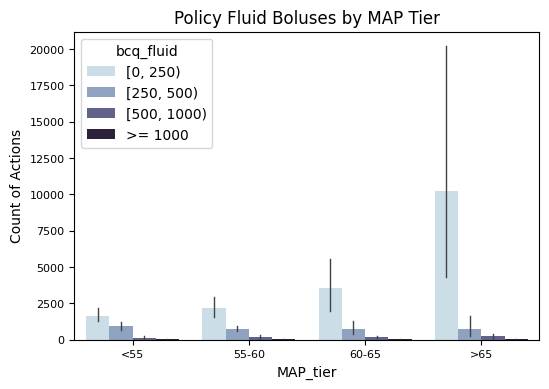

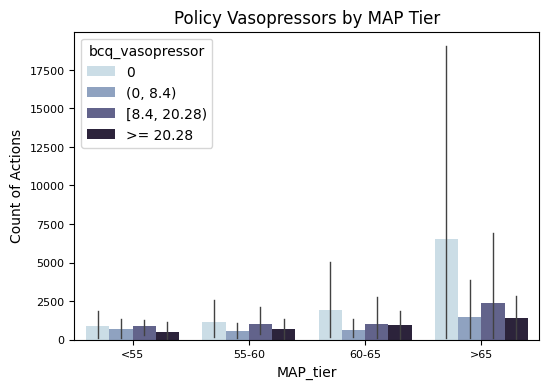

In [135]:
# Plotting fluid bolus comparison
plt.figure(figsize=(6, 4))
sns.barplot(data=bcq_action_counts, x='MAP_tier', y='bcq_count', hue='bcq_fluid', palette="ch:s=.25,rot=-.25", err_kws={'linewidth': 1})
plt.title('Policy Fluid Boluses by MAP Tier')
plt.ylabel('Count of Actions')
plt.tick_params(labelsize=8)
plt.show()

# Plotting vasopressor comparison
plt.figure(figsize=(6, 4))
sns.barplot(data=bcq_action_counts, x='MAP_tier', y='bcq_count', hue='bcq_vasopressor', palette="ch:s=.25,rot=-.25", err_kws={'linewidth': 1})
plt.title('Policy Vasopressors by MAP Tier')
plt.ylabel('Count of Actions')
plt.tick_params(labelsize=8)
plt.show()

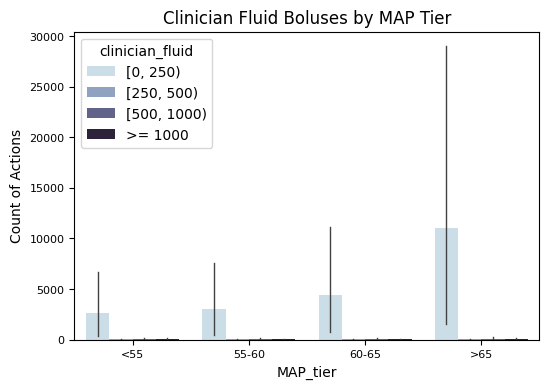

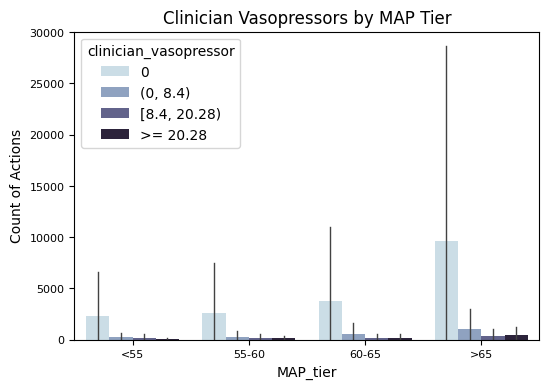

In [136]:
# Plotting fluid bolus comparison
plt.figure(figsize=(6, 4))
sns.barplot(data=clinician_action_counts, x='MAP_tier', y='clinician_count', hue='clinician_fluid', palette="ch:s=.25,rot=-.25", err_kws={'linewidth': 1})
plt.title('Clinician Fluid Boluses by MAP Tier')
plt.ylabel('Count of Actions')
plt.tick_params(labelsize=8)
plt.show()

# Plotting vasopressor comparison
plt.figure(figsize=(6, 4))
sns.barplot(data=clinician_action_counts, x='MAP_tier', y='clinician_count', hue='clinician_vasopressor', palette="ch:s=.25,rot=-.25", err_kws={'linewidth': 1})
plt.title('Clinician Vasopressors by MAP Tier')
plt.ylabel('Count of Actions')
plt.tick_params(labelsize=8)
plt.show()